In [2]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
import json
import copy
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time

In [3]:
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.visualizations import sum_it, data_iterations, plot_accuracies
from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.network import load_model, train_network, accuracy_per_class
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.test_dataset_background import TestDataset as TestDatasetBackground
from expbasics.crp_attribution import CRPAttribution
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

%reload_ext autoreload
%autoreload 2


plt.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.family': 'serif', "font.size": 14})

accuracy below 80%: 44
bad biases:  [[1, 0.0, 72.65513610839844], [14, 0.0, 59.0030517578125], [14, 0.02, 67.22278594970703], [1, 0.04, 67.18209075927734], [14, 0.04, 66.67344665527344], [6, 0.06, 70.11190032958984], [14, 0.06, 75.99185943603516], [1, 0.08, 68.95218658447266], [14, 0.08, 67.81282043457031], [14, 0.12, 66.99898529052734], [1, 0.14, 66.75482940673828], [6, 0.14, 69.5422134399414], [14, 0.16, 67.30416870117188], [14, 0.18, 73.04170989990234], [1, 0.26, 67.22278594970703], [14, 0.26, 64.10986328125], [1, 0.3, 61.078330993652344], [14, 0.34, 70.72227478027344], [1, 0.36, 67.22278594970703], [14, 0.36, 66.95829010009766], [1, 0.38, 67.18209075927734], [14, 0.4, 65.92064666748047], [14, 0.42, 58.982704162597656], [14, 0.48, 65.33061981201172], [1, 0.5, 63.397762298583984], [6, 0.54, 60.467952728271484], [14, 0.58, 63.316375732421875], [6, 0.6, 49.88809585571289], [14, 0.6, 58.982704162597656], [1, 0.64, 64.6592025756836], [6, 0.64, 57.7619514465332], [14, 0.68, 69.42014312744

[[1, 0.0, 72.65513610839844],
 [14, 0.0, 59.0030517578125],
 [14, 0.02, 67.22278594970703],
 [1, 0.04, 67.18209075927734],
 [14, 0.04, 66.67344665527344],
 [6, 0.06, 70.11190032958984],
 [14, 0.06, 75.99185943603516],
 [1, 0.08, 68.95218658447266],
 [14, 0.08, 67.81282043457031],
 [14, 0.12, 66.99898529052734],
 [1, 0.14, 66.75482940673828],
 [6, 0.14, 69.5422134399414],
 [14, 0.16, 67.30416870117188],
 [14, 0.18, 73.04170989990234],
 [1, 0.26, 67.22278594970703],
 [14, 0.26, 64.10986328125],
 [1, 0.3, 61.078330993652344],
 [14, 0.34, 70.72227478027344],
 [1, 0.36, 67.22278594970703],
 [14, 0.36, 66.95829010009766],
 [1, 0.38, 67.18209075927734],
 [14, 0.4, 65.92064666748047],
 [14, 0.42, 58.982704162597656],
 [14, 0.48, 65.33061981201172],
 [1, 0.5, 63.397762298583984],
 [6, 0.54, 60.467952728271484],
 [14, 0.58, 63.316375732421875],
 [6, 0.6, 49.88809585571289],
 [14, 0.6, 58.982704162597656],
 [1, 0.64, 64.6592025756836],
 [6, 0.64, 57.7619514465332],
 [14, 0.68, 69.4201431274414],


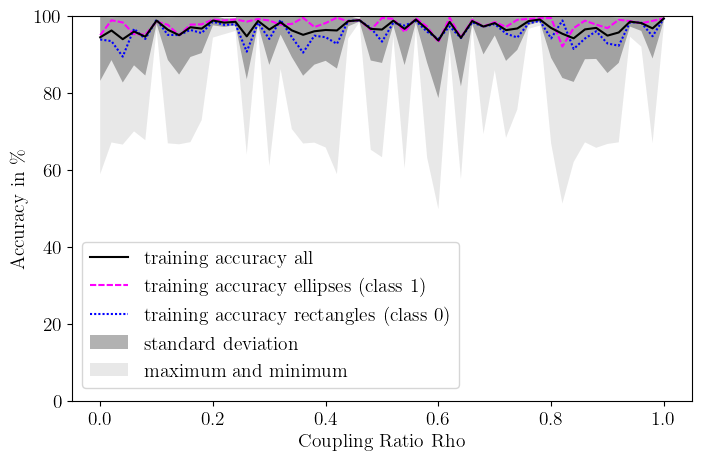

In [4]:
plot_accuracies(
    "outputs/retrain.json", 80, num_it=16, intervened=False
)

In [9]:
MODEL_ZOO_INFOS_PATH = "outputs/final_models.json"#"outputs/seeded_model_accuracies.json"
MODEL_NAME = "../clustermodels/background"#background final
with open(MODEL_ZOO_INFOS_PATH, "r") as f:
    modelzoo = json.load(f)


MAX_INDEX = 491520
STEP_SIZE = 40200 # 1033, 2011, 2777, 5381, 7069, 13267, 18181
indices = range(0, MAX_INDEX, STEP_SIZE)
LAYER_NAME = "convolutional_layers.6"#"linear_layers.0"

print(len(indices))

13


In [4]:
from expbasics.visualizations import data_iterations

datas, bis, biases, alldata = data_iterations(MODEL_ZOO_INFOS_PATH, num_it=16)

# [a["train_accuracy"][2] for a in datas[9]]

In [14]:
from expbasics.plotting import draw_graph_with_images
from expbasics.test_dataset import  TestDataset
from expbasics.background_dataset import BackgroundDataset
b = 1.0
num_it = 8
model = load_model(MODEL_NAME, b, num_it, model_type="overlap")
model_name = f"background_{to_name(b, num_it)}"
#ds = BackgroundDataset(0.0, 0.5)
#ds = TestDataset(length=300, im_dir="watermark_test_data")
ds = TestDatasetBackground(length=300, im_dir="overlap_test_data")
crpa = CRPAttribution(model, ds, MODEL_NAME, model_name, max_target="sum")

#nodes, edges, images = crpa.complete_relevance_graph(50)
#draw_graph_with_images(nodes, edges, images)

res = crpa.compute_feature_vis()



computing feature vis
len dataset 300
Running Analysis...


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


100%|██████████| 10/10 [00:00<00:00, 2045.50it/s]


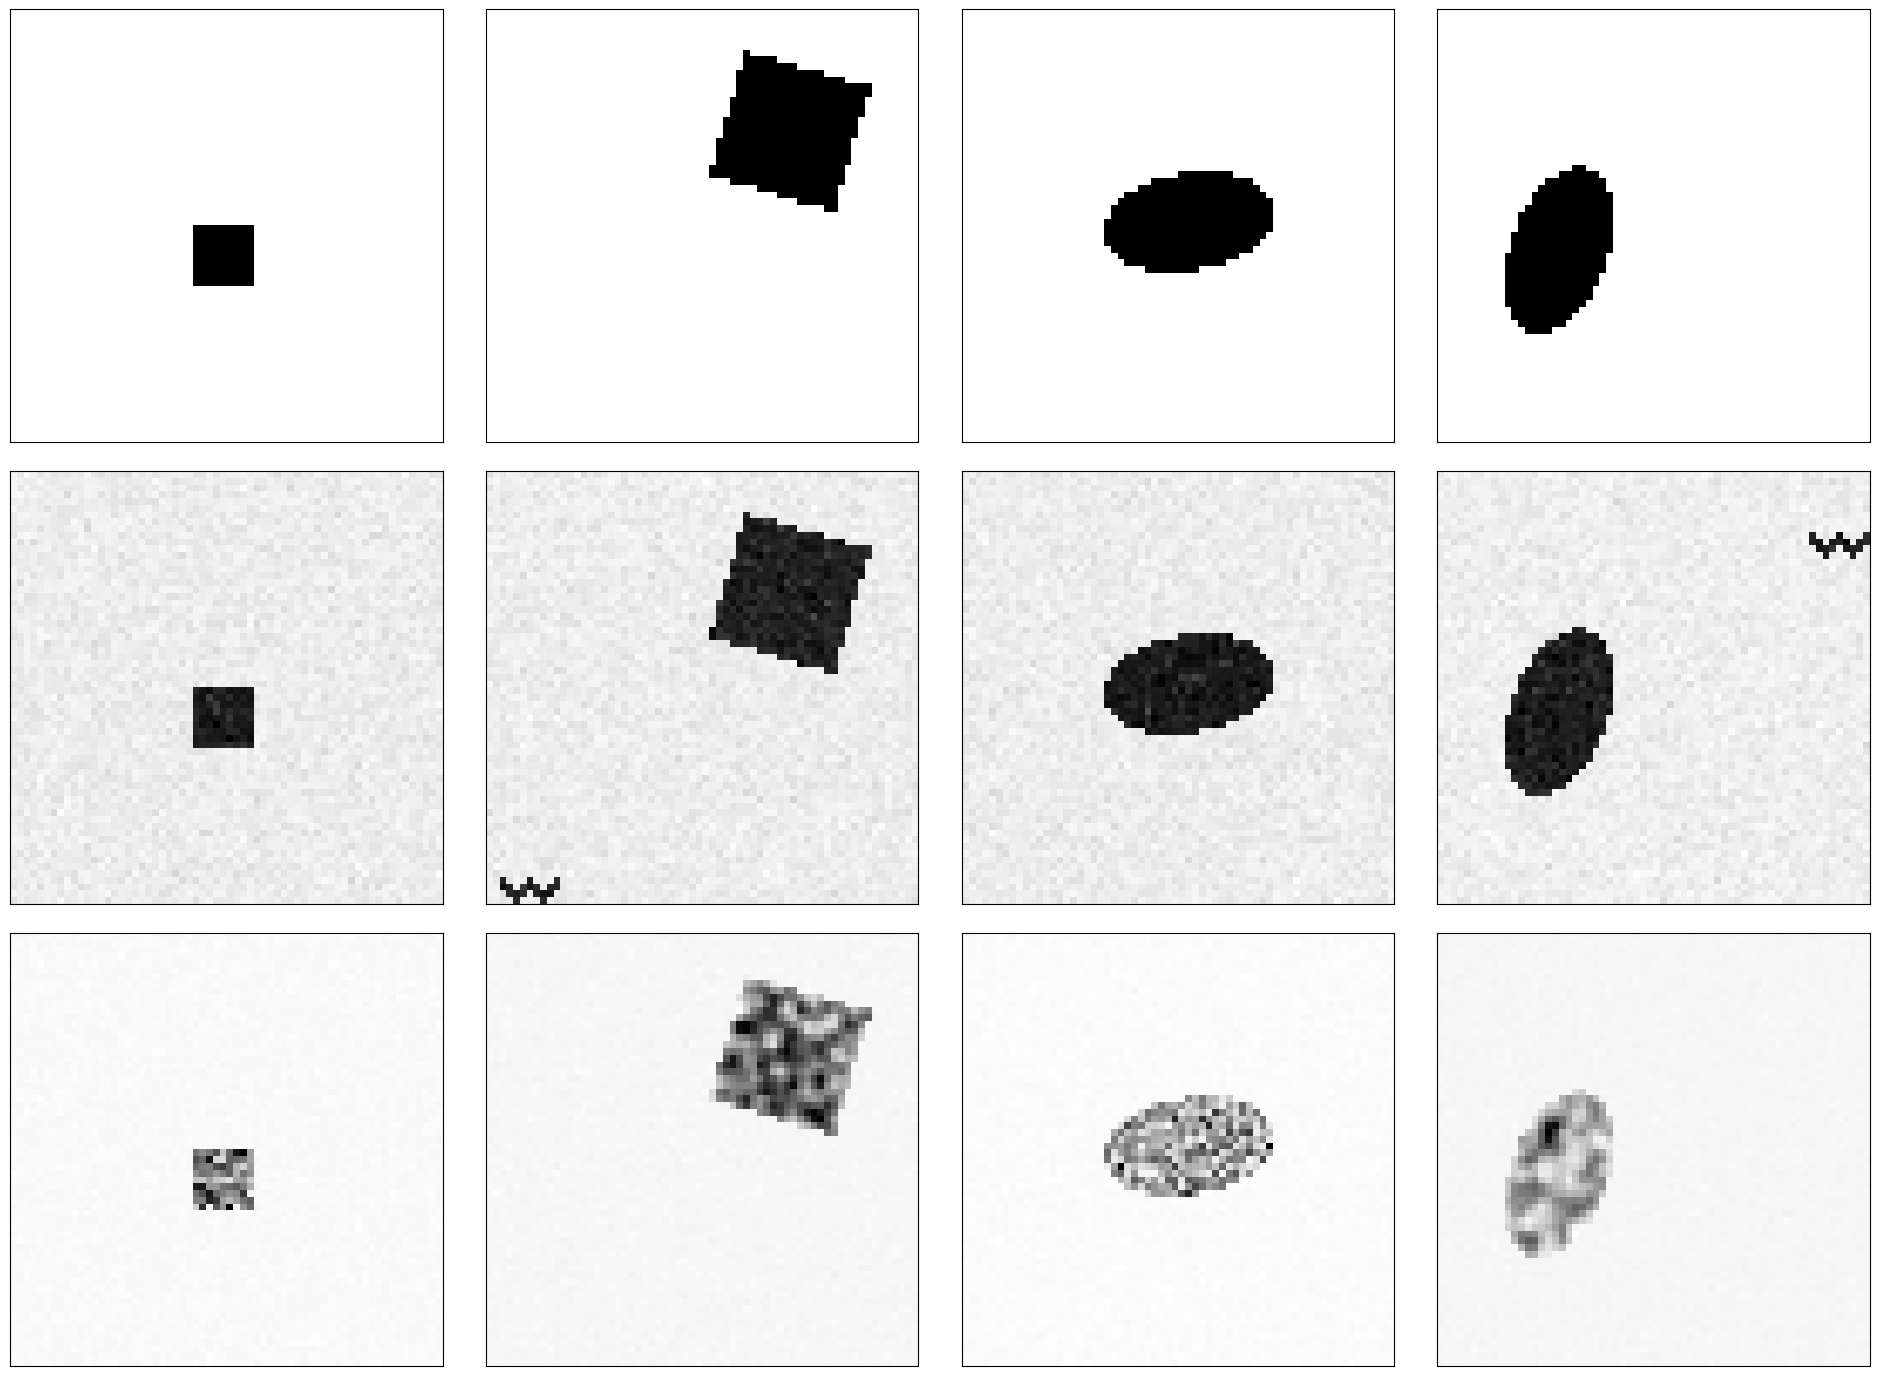

In [38]:

from expbasics.background_dataset import BackgroundDataset
from expbasics.visualizations import my_plot_grid
ds = BiasedNoisyDataset(0.0, 0.5)
bds = BackgroundDataset(0.0, 0.5)
imgs = torch.zeros(3,4,64,64)

imgs[0,0] = ds.load_shape_mask(500)[0,0]
imgs[0,1] = ds.load_shape_mask(213890)[0,0]
imgs[0,2] = ds.load_shape_mask(452143)[0,0]
imgs[0,3] = ds.load_shape_mask(478291)[0,0]
imgs[1,0] = ds.load_image_wm(500, False)
imgs[1,1] = ds.load_image_wm(213890, True)
imgs[1,2] = ds.load_image_wm(452143, False)
imgs[1,3] = ds.load_image_wm(478291, True)
imgs[2,0] = bds.load_image_wm(500, False)
imgs[2,1] = bds.load_image_wm(213890, True)
imgs[2,2] = bds.load_image_wm(452143, False)
imgs[2,3] = bds.load_image_wm(478291, True)
#imgs = imgs.view(8,64,64)
imgs = imgs.detach()
my_plot_grid(imgs, 3,4, resize=6)

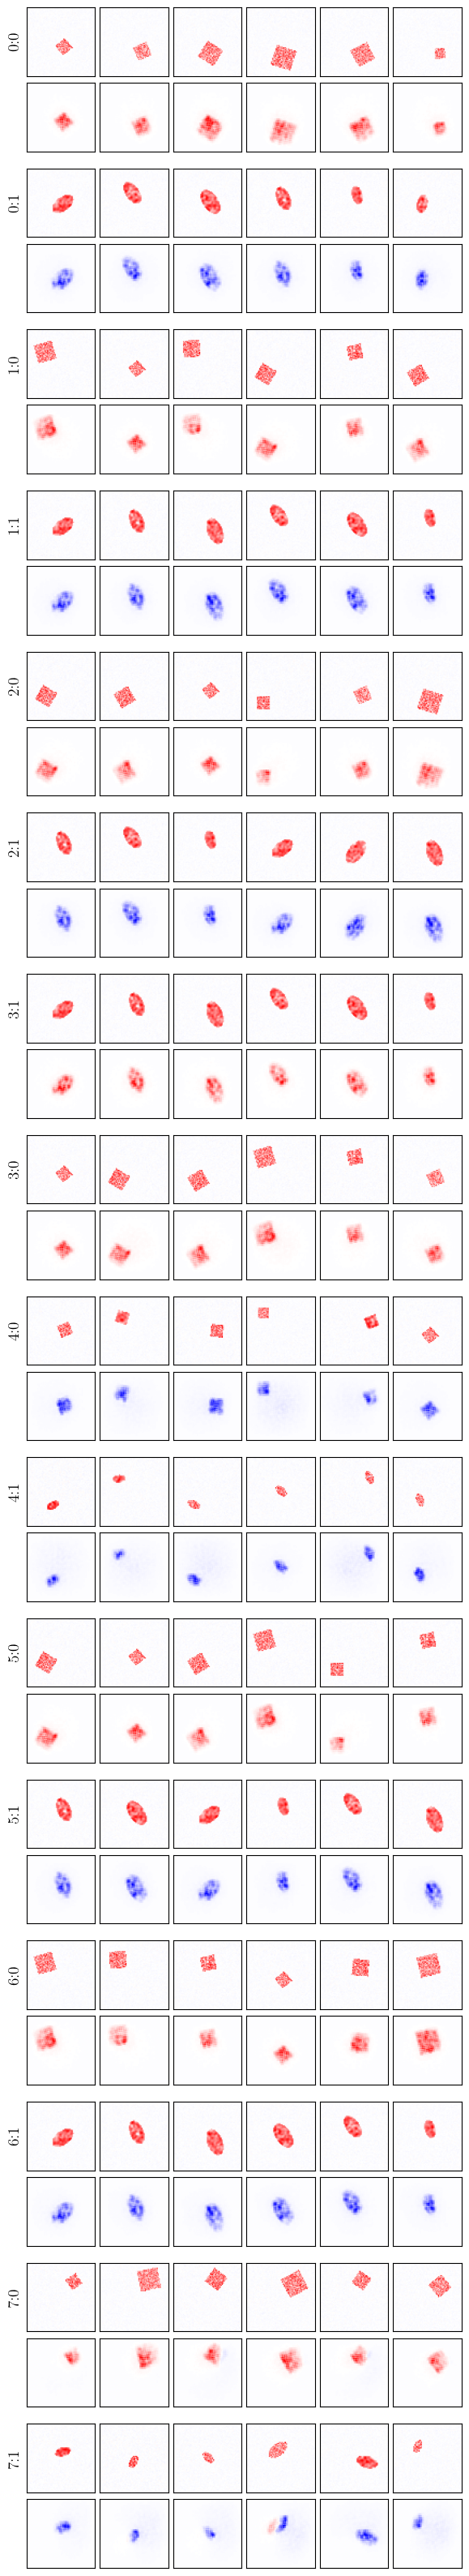

In [15]:
crpa.make_stats_references(LAYER_NAME, range(8), "relevance")

In [186]:
neuron = 6

targets, relevances = crpa.fv.compute_stats(neuron, LAYER_NAME, "relevance", top_N=2, norm=False, mean_N=5)
for t in targets:
    print(crpa.fv.get_stats_reference(
                    neuron,
                    LAYER_NAME,
                    [t],
                    "relevance",
                    (0, 8),
                    composite=crpa.composite,
                    rf=True,
                    # plot_fn=vis_heat,
                ))

{'6:0': ([<PIL.PngImagePlugin.PngImageFile image mode=P size=30x27 at 0x7F76A556FFD0>, <PIL.PngImagePlugin.PngImageFile image mode=P size=26x30 at 0x7F76A556CDF0>, <PIL.PngImagePlugin.PngImageFile image mode=P size=24x24 at 0x7F76A556FB20>, <PIL.PngImagePlugin.PngImageFile image mode=P size=31x24 at 0x7F76A556E980>, <PIL.PngImagePlugin.PngImageFile image mode=P size=27x25 at 0x7F76A556FE20>, <PIL.PngImagePlugin.PngImageFile image mode=P size=31x31 at 0x7F76A556E9E0>, <PIL.PngImagePlugin.PngImageFile image mode=P size=33x29 at 0x7F76A556F4F0>, <PIL.PngImagePlugin.PngImageFile image mode=P size=28x25 at 0x7F76A556DA80>], [<PIL.PngImagePlugin.PngImageFile image mode=P size=30x27 at 0x7F76A556E2F0>, <PIL.PngImagePlugin.PngImageFile image mode=P size=26x30 at 0x7F76A556DFC0>, <PIL.PngImagePlugin.PngImageFile image mode=P size=24x24 at 0x7F76A556CD00>, <PIL.PngImagePlugin.PngImageFile image mode=P size=31x24 at 0x7F76A556E230>, <PIL.PngImagePlugin.PngImageFile image mode=P size=27x25 at 0x7F

In [ ]:
image = ds.load_watermark_mask(3199)

images = torch.zeros(4,64,64)
images[0] = image[0,0]
blurry = ds.blur(image)
print(blurry.max())
images[1] = blurry[0,0]
imagelarge = (blurry > 0.0).int()
images[2] = imagelarge[0,0]
imagesmall = (blurry > 0.5).int()
images[3] = imagesmall[0,0] 
imgify(images,grid=(1,4), resize=600)

{'r_max': ['crp-data/background_b1_0-i8_fv/RelMax_sum_normed/linear_layers.2_', 'crp-data/background_b1_0-i8_fv/RelMax_sum_normed/linear_layers.0_', 'crp-data/background_b1_0-i8_fv/RelMax_sum_normed/convolutional_layers.6_', 'crp-data/background_b1_0-i8_fv/RelMax_sum_normed/convolutional_layers.3_', 'crp-data/background_b1_0-i8_fv/RelMax_sum_normed/convolutional_layers.0_'], 'a_max': ['crp-data/background_b1_0-i8_fv/ActMax_sum_normed/convolutional_layers.0_', 'crp-data/background_b1_0-i8_fv/ActMax_sum_normed/convolutional_layers.3_', 'crp-data/background_b1_0-i8_fv/ActMax_sum_normed/convolutional_layers.6_', 'crp-data/background_b1_0-i8_fv/ActMax_sum_normed/linear_layers.0_', 'crp-data/background_b1_0-i8_fv/ActMax_sum_normed/linear_layers.2_'], 'r_stats': ['crp-data/background_b1_0-i8_fv/RelStats_sum_normed/linear_layers.2/0_', 'crp-data/background_b1_0-i8_fv/RelStats_sum_normed/linear_layers.0/0_', 'crp-data/background_b1_0-i8_fv/RelStats_sum_normed/convolutional_layers.6/0_', 'crp-da

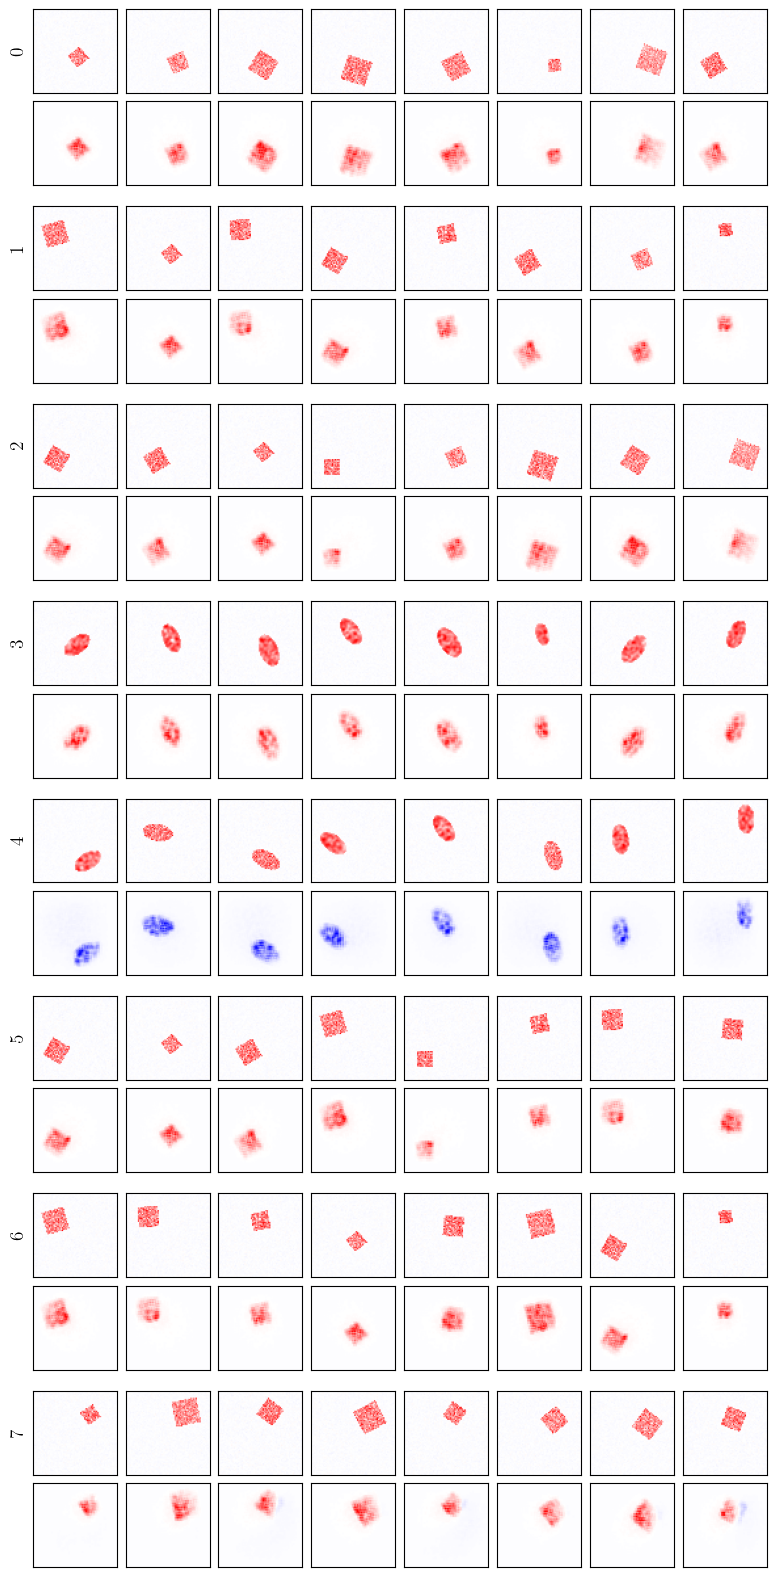

In [16]:

print(res)
layer = "convolutional_layers.6" #"linear_layers.0" #
neurons = range(8)
crpa.make_all_references(layer , neurons, relact="relevance") # "convolutional_layers.6" "linear_layers.0"

In [112]:

from sklearn.metrics import matthews_corrcoef, normalized_mutual_info_score

with open(
    f"{crpa.fv_path}/RelMax_sum_normed/convolutional_layers.6_data.npy", "rb"
) as f:
    data = np.load(f)
len_set = 40
info = np.zeros((8, len_set, 3), dtype=np.int64)
overlap = np.zeros((8, 5))
for neuron in range(8):
    indices = data[:len_set, neuron]
    for i, ind in enumerate(indices):
        img, label = ds[ind]
        (latents, has_watermark, offset) = ds.get_item_info(ind)
        info[neuron, i, 0] = ind
        info[neuron, i, 1] = label
        info[neuron, i, 2] = int(has_watermark)
    overlap[neuron, 0] = np.count_nonzero(info[neuron, :, 2]) / (2*max(
        np.count_nonzero(info[neuron, :, 1] == 1),
        np.count_nonzero(info[neuron, :, 1] == 0),
    ))
    overlap[neuron, 1] = np.count_nonzero(info[neuron, :, 2])
    overlap[neuron, 2] = max(
        np.count_nonzero(info[neuron, :, 1] == 1),
        np.count_nonzero(info[neuron, :, 1] == 0),
    )
    overlap[neuron, 3] = matthews_corrcoef(info[neuron, :, 2], info[neuron, :, 1])
    overlap[neuron, 4] = normalized_mutual_info_score(info[neuron, :, 1], info[neuron, :, 2])
#overlap[:,0] -= 0.5
print(overlap)

[[ 0.125      10.         40.          0.          0.        ]
 [ 0.0625      5.         40.          0.          0.        ]
 [ 0.38709677 24.         31.          0.43994135  0.22588072]
 [ 0.35       28.         40.          0.          0.        ]
 [ 0.38571429 27.         35.          0.54470478  0.31812077]
 [ 0.53448276 31.         29.          0.87486907  0.71838725]
 [ 0.3125     25.         40.          0.          0.        ]
 [ 0.34210526 26.         38.          0.31264095  0.12996929]]


convolutional_layers.0 0 tensor(-21.7903) tensor(15360.7686)
convolutional_layers.3 1 tensor(-30.3629) tensor(2910.7178)
linear_layers.0 3 tensor(1.4641) tensor(2.6712)
linear_layers.2 4 tensor(-0.0939) tensor(0.1855)


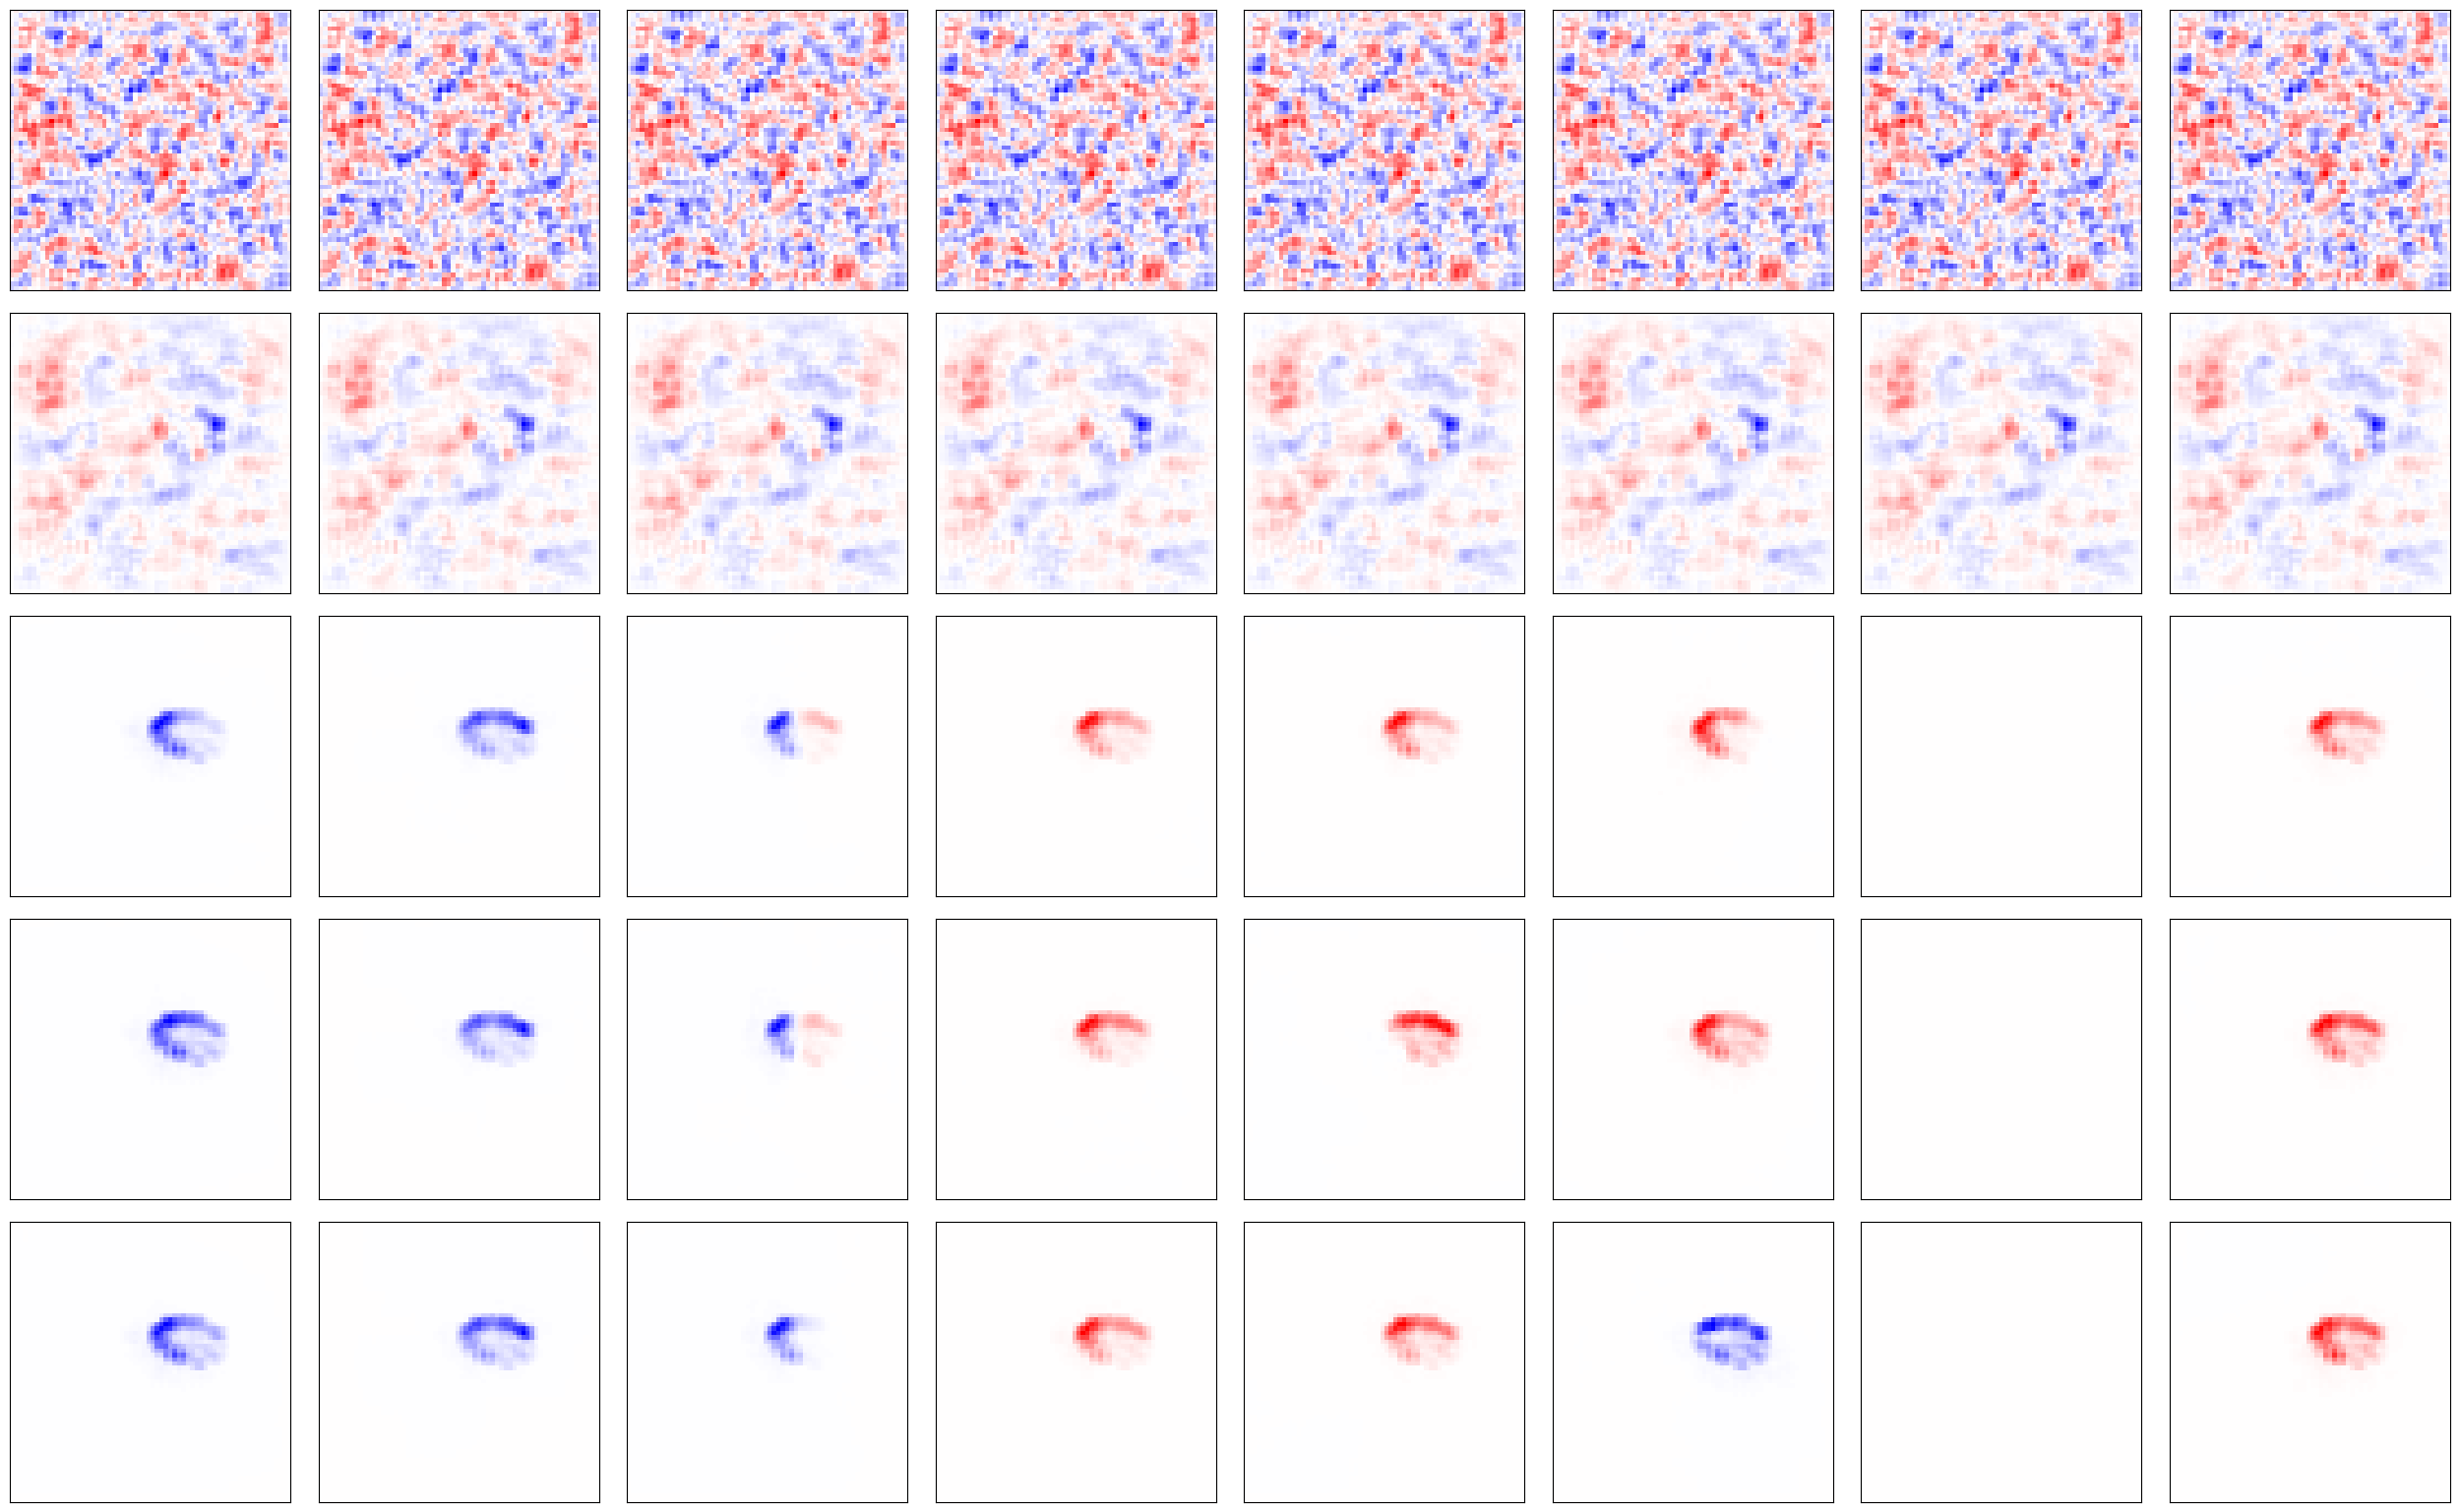

In [33]:
from expbasics.visualizations import my_plot_grid


ds = BiasedNoisyDataset(0.0, 0.5)
image = ds.load_image_wm(305931, False)
heatmaps = torch.zeros(5,8,64,64)
for li, l in enumerate(crpa.layer_id_map.keys()):
    if l != "convolutional_layers.6":
        random_init = torch.zeros(8,*crpa.output_shape[l])
        rand_init = torch.rand(crpa.output_shape[l]) * 2 -1
        random_init[:] = rand_init / rand_init.sum()
        res = crpa.attribution(
            image,
            [{"convolutional_layers.6": [i]} for i in range(8)],
            crpa.composite,
            record_layer=crpa.layer_names,
            start_layer=l,
            init_rel= random_init,
            exclude_parallel=False
        )
        heatmaps[li] = res.heatmap
        print(l, li, rand_init.sum(),rand_init.abs().sum())
    else: 
        res = crpa.attribution(
            image,
            [{"convolutional_layers.6": [i]} for i in range(8)],
            crpa.composite,
            record_layer=crpa.layer_names,
            start_layer="linear_layers.2",
            exclude_parallel=False
        )
        heatmaps[li] = res.heatmap

my_plot_grid(heatmaps, 5,8, 4, norm=False)

convolutional_layers.0 0 tensor(25.2127) tensor(15273.8994)
convolutional_layers.3 1 tensor(18.4919) tensor(2879.2258)
convolutional_layers.6 2 tensor(18.8276) tensor(200.1175)
linear_layers.0 3 tensor(1.7293) tensor(1.9722)


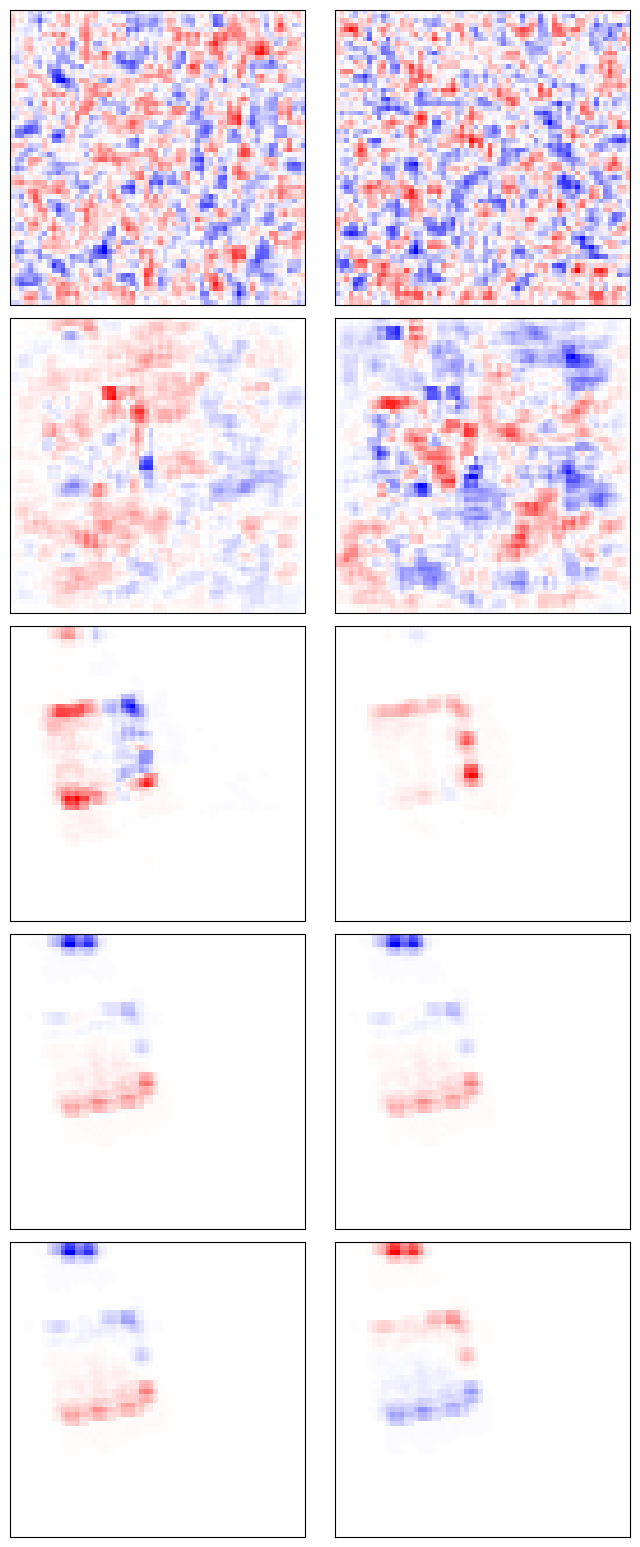

In [41]:

image = ds.load_image_wm(205931, True)
heatmaps = torch.zeros(5,2,64,64)
for li, l in enumerate(crpa.layer_id_map.keys()):
    if l != "linear_layers.2":
        random_init = torch.zeros(2,*crpa.output_shape[l])
        rand_init = torch.rand(crpa.output_shape[l]) * 2 -1
        random_init[:] = rand_init / rand_init.abs().sum()
        res = crpa.attribution(
            image,
            [{"linear_layers.2": [i]} for i in range(2)],
            crpa.composite,
            record_layer=crpa.layer_names,
            start_layer=l,
            init_rel= rand_init,
            exclude_parallel=False
        )
        heatmaps[li] = res.heatmap
        print(l, li, rand_init.sum(),rand_init.abs().sum())
    else: 
        res = crpa.attribution(
            image,
            [{"y": [i]} for i in range(2)],
            crpa.composite,
            record_layer=crpa.layer_names,
            exclude_parallel=False
        )
        heatmaps[li] = res.heatmap

my_plot_grid(heatmaps, 5,2, 4, norm=False)

output: tensor([[-1.1307,  3.4249]]), 
 latents: [ 0  0  0 31  8], watermark: True, prediction:1 
 convolutional_layers.0: 
 0: 0.22, 1: -0.1, 2: -0.05, 3: 0.29, 4: 0.04, 5: -0.11, 6: 0.07, 7: -0.11 
 convolutional_layers.3: 
 0: -0.07, 1: -0.04, 2: -0.3, 3: -0.06, 4: -0.1, 5: -0.08, 6: -0.04, 7: -0.31 
 convolutional_layers.6: 
 0: 0.1, 1: -0.13, 2: 0.1, 3: 0.15, 4: 0.21, 5: 0.04, 6: -0.16, 7: 0.12 
 linear_layers.0: 
 0: 0.39, 1: -0.03, 2: -0.2, 3: 0.33, 4: -0.02, 5: -0.03 
 linear_layers.2: 
 0: -0.25, 1: 0.75 


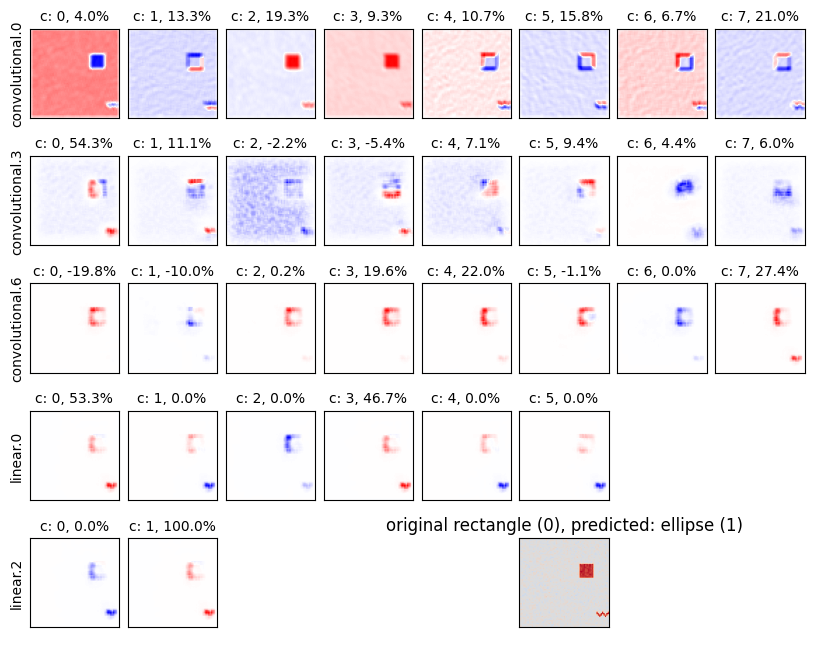

In [11]:
rel = crpa.image_info(1000, verbose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

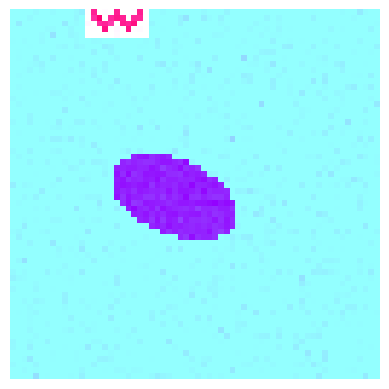

In [124]:
res = crpa.watermark_importance(260)
image = copy.deepcopy(ds[260][0])
img = torch.zeros(64,64,3)
img[:,:,1] = (image[0] * -1) + 0.5
img[:,:,2] = (image[0] * res["mask"] * -1) + 1
img[np.where(res["mask"] == 1)[0],np.where(res["mask"] == 1)[1],0] = 1
img = (img - img.min()) / img.max()
plt.imshow(img, cmap="gray")
plt.axis("off")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

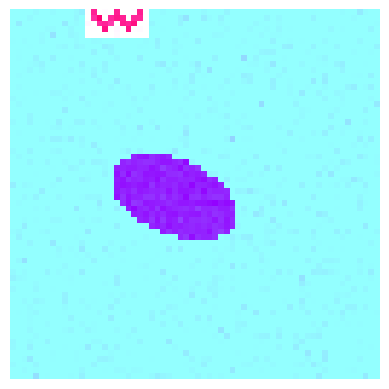

In [125]:
image = copy.deepcopy(ds[260][0])
mask = ds.load_watermark_mask(260)
img = torch.zeros(64,64,3)
img[:,:,1] = (image[0] * -1) + 0.5
img[:,:,2] = (image[0] * mask * -1) + 1
img[np.where(mask == 1)[0],np.where(mask == 1)[1],0] = 1
img = (img - img.min()) / img.max()
plt.imshow(img, cmap="gray")
plt.axis("off")

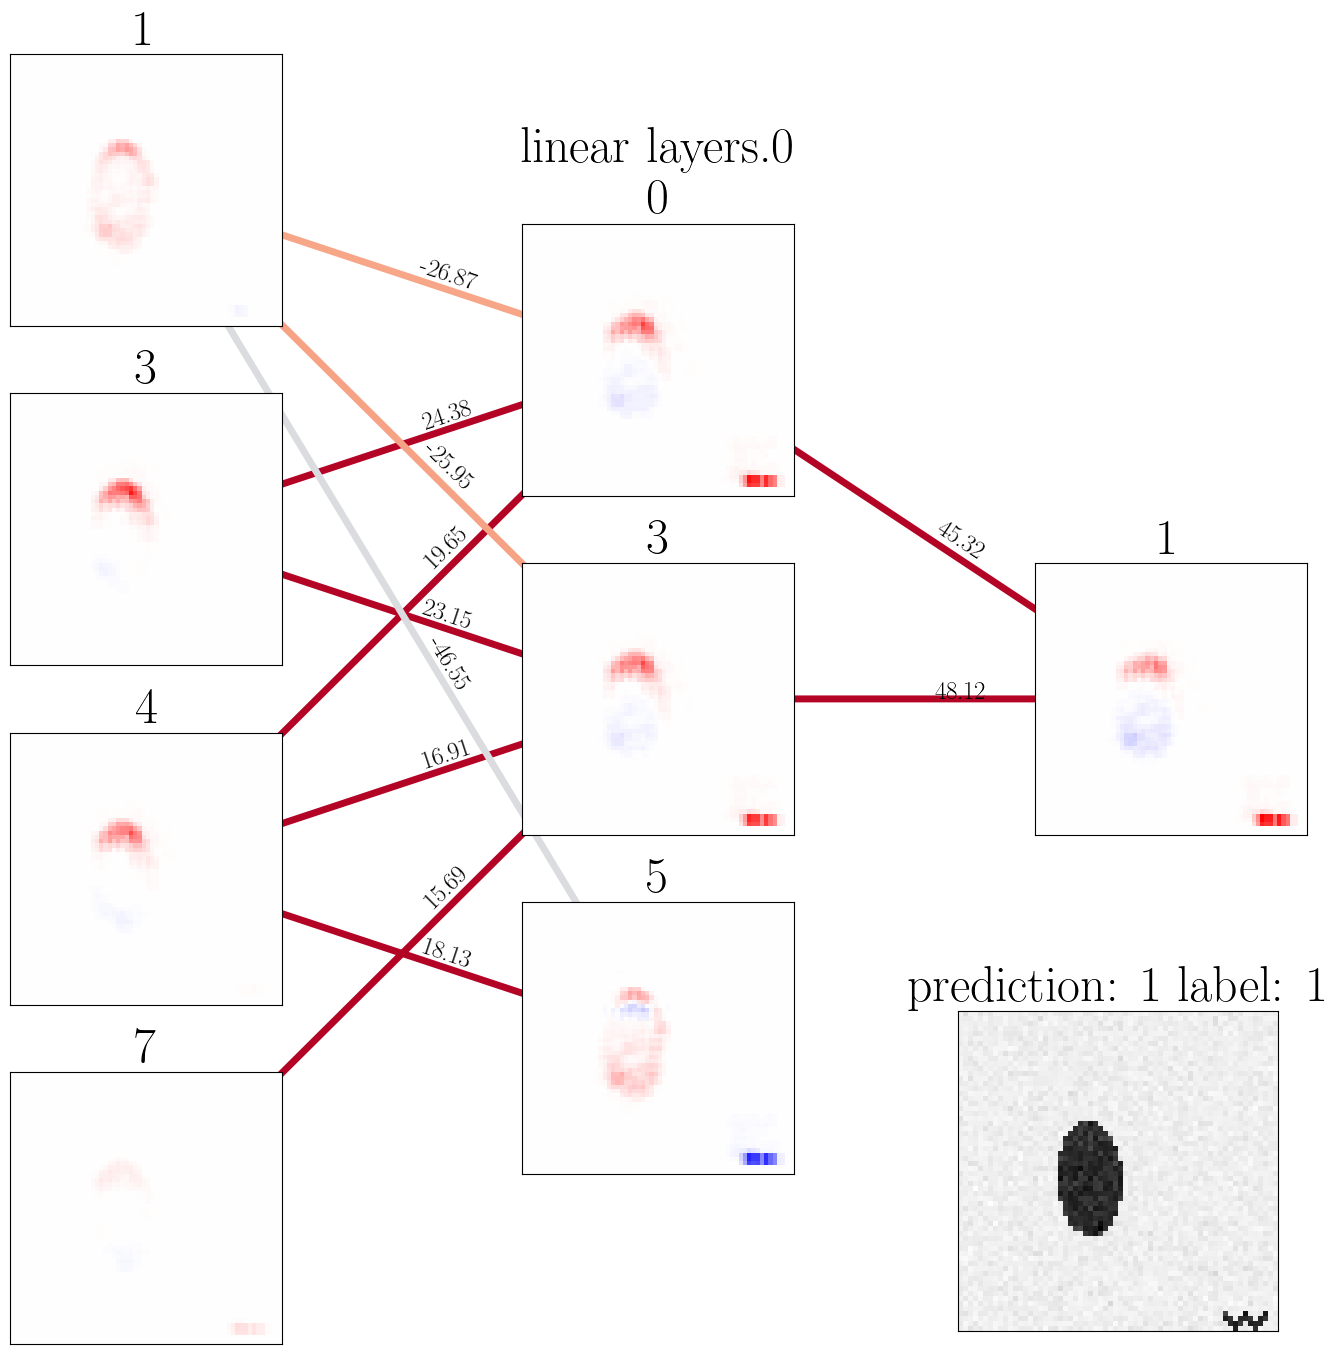

In [290]:
b, m = 0.96, 7

# 854
index = 854
model = load_model(MODEL_NAME, b, m )
model_name = to_name(b, m )
crpa = CRPAttribution(model, ds, MODEL_NAME, model_name)

nodes, edges, images = crpa.complete_relevance_graph(index)
draw_graph_with_images(nodes, edges, images)

Counter({-1: 2506, 5: 675, 3: 399, 0: 262, 1: 118, 2: 88, 4: 48})


(-0.5, 63.5, 63.5, -0.5)

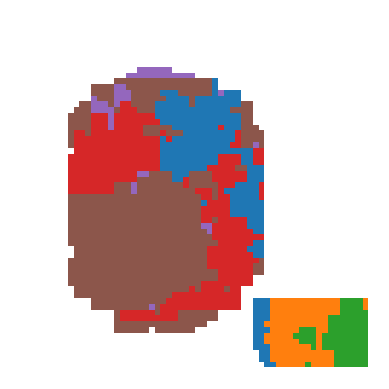

In [291]:
from expbasics.visualizations import my_plot_grid
from collections import Counter

chms = torch.zeros(6, 64, 64)

""" for neuron in range(8):
    chms[neuron] = images[f"convolutional_layers.6_{neuron}"][0] """
for neuron in range(6):
    chms[neuron] = images[f"linear_layers.0_{neuron}"][0]

maxact = torch.max(chms.abs(), dim=0)
concept_atlas = torch.where(maxact.values == 0, 0, maxact.indices + 1)
print(Counter((concept_atlas -1).flatten().tolist()))
cs = [
    (1, 1, 1),
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
    (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
    (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
    (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
    (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0),
]


cm = matplotlib.colors.ListedColormap(cs)
plt.imshow(concept_atlas, cmap=cm, vmin=0, vmax=10)
""" fig = plt.figure(figsize=(6.4,6.4))
for i in range(64):
    for j in range(64):
        plt.scatter(j,i, color=colors[concept_atlas[i,j]],marker="s") """
plt.axis("off")

(-0.5, 9.5, 1.5, -0.5)

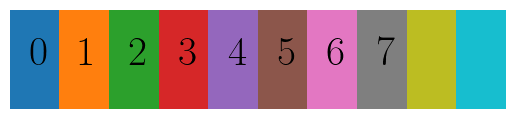

In [289]:
gradient = np.linspace(0, 1, 10)
gradient = np.vstack((gradient, gradient))
res = plt.imshow(gradient, cmap="tab10")
print()
for i in range(8):
    plt.text( i- 0.1,0.6, str(i))
plt.axis("off")

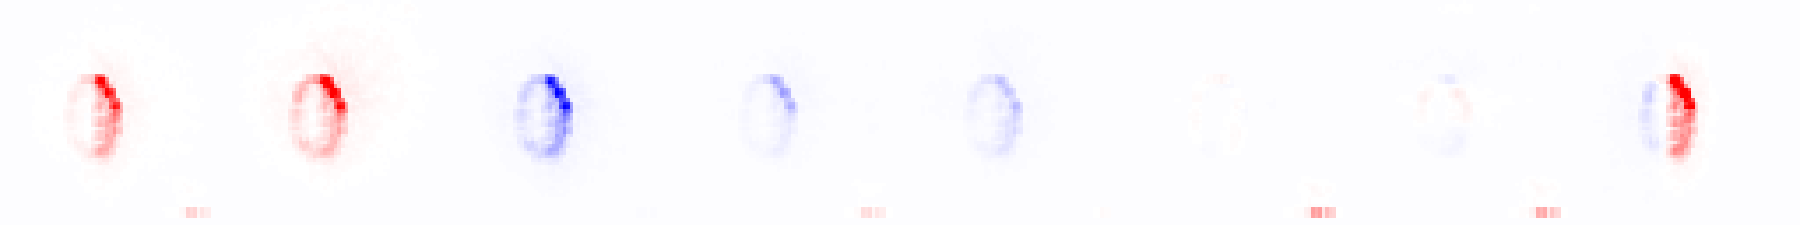

In [281]:
imgify(chms, resize=1800,vmax=.5,vmin=-0.5, grid=(1,8))

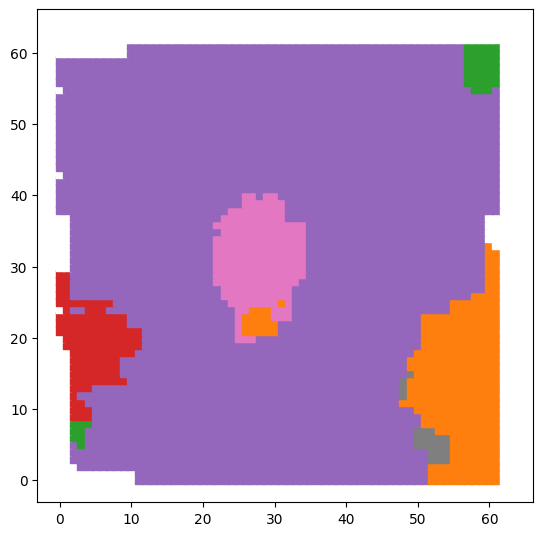

In [223]:
fig = plt.figure(figsize=(6.4,6.4))
for i in range(64):
    for j in range(64):
        plt.scatter(j,i, color=cs[concept_atlas[i,j]],marker="s")

In [248]:
c =  matplotlib.cm.get_cmap('tab10')
print([c(i) for i in range(10)])

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]


/tmp/ipykernel_2597324/250047823.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c =  matplotlib.cm.get_cmap('tab10')


(-0.5, 63.5, 63.5, -0.5)

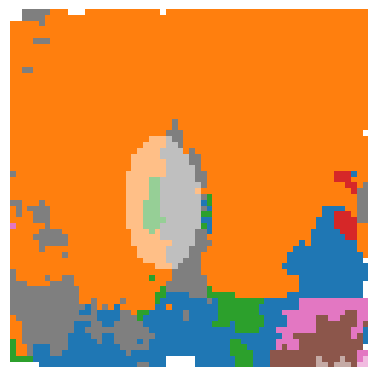

In [273]:
img = cm(concept_atlas)
realimg = images["original"][0] > 0.5 

img[:,:,3] -= 0.5*realimg
plt.imshow(img)
plt.axis("off")

In [ ]:

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111, frame_on=False)

nodes = ["N_w", "N_s", "G", "S", "W", "TS", "i", "M", "P", "E"]
edges = [
    ("N_w", "W"),
    ("N_s", "S"),
    ("G", "W"),
    ("G", "S"),
    ("L", "TS"),
    ("L", "i"),
    ("W", "TS"),
    ("W", "i"),
    ("S", "TS"),
    ("S", "i"),
    ("TS", "M"),
    ("M", "P"),
    ("i", "P"),
    ("G", "P"),
    ("P", "E"),
    ("i", "E"),
    ("M", "E"),
]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx(
    G,
    ax=ax,
    pos=pos,
)

In [ ]:
res =crpa.image_info(400,verbose=True, onlywm=True)

In [ ]:
from expbasics.visualizations import my_plot_grid

indices = range(0, MAX_INDEX, 64300)
print(list(indices))
images = torch.zeros(2, 4, 64, 64)
for i, index in enumerate([0, 128600, 257200, 385800]):
    images[0, i] = ds[index][0]
    images[1, i], pred = crpa.heatmap(index)


my_plot_grid(images, 2, 4, resize=4)

In [ ]:
im_frame = Image.open('suppresor.png')
im_frame.thumbnail((64,64), Image.Resampling.LANCZOS)
im_frame = im_frame.convert("")
np_frame = torch.tensor(np.array(im_frame))
vals = np_frame[:,:,0]
vals = (vals +1) % 2
image, wm = ds[200003]

""" image = np.load("../dsprites-dataset/images/200003.npy", mmap_mode="r")
image = torch.from_numpy(np.asarray(image, dtype=np.float32)).view(1, 64, 64) """
p = 0.7
test = image[0]*(p*vals + (1-p)*np.random.normal(0.0, 0.1, (64, 64)))
plt.imshow(test, cmap="Greys")
plt.axis("off")

with open(f"suppressor.npy", "wb") as f:
    np.save(f, vals.numpy(), allow_pickle=True)

In [2]:
from measures0_to_2 import AllMeasures
%reload_ext autoreload
%autoreload 2

layer_name = "convolutional_layers.6"
allm = AllMeasures("../dsprites-dataset/images/", 10)
allm.recompute_measures(layer_name, ["m2_crv","m1_phi"])

  0%|          | 0/2 [00:00<?, ?it/s, m=0]


AttributeError: 'numpy.ndarray' object has no attribute 'abs'